# Learning in LTN

This tutorial explains how to learn some language symbols (predicates, functions, constants) using the satisfaction of a knowledgebase as an objective. It expects basic familiarity of the first two turoials on LTN (grounding symbols and connectives).

In [ ]:
import logictensornetworks as ltn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

We use the following simple example to illustrate learning in LTN.

The domain is the square $[0,4] \times [0,4]$. We have one example of the class $A$ and one example of the class $B$. The rest of the individuals are not labelled, but there are two assumptions:
- $A$ and $B$ are mutually exclusive,
- any two close points should share the same label.

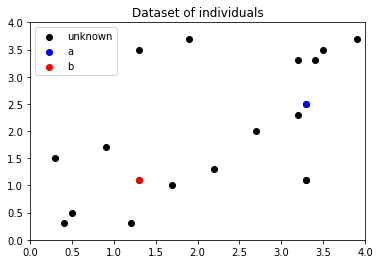

In [33]:
points = np.array(
        [[0.4,0.3],[1.2,0.3],[2.2,1.3],[1.7,1.0],[0.5,0.5],[0.3, 1.5],[1.3, 1.1],[0.9, 1.7],
        [3.4,3.3],[3.2,3.3],[3.2,2.3],[2.7,2.0],[3.5,3.5],[3.3, 2.5],[3.3, 1.1],[1.9, 3.7],[1.3, 3.5],[3.3, 1.1],[3.9, 3.7]])
point_a = [3.3,2.5]
point_b = [1.3,1.1]
fig, ax = plt.subplots()
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.scatter(points[:,0],points[:,1],color="black",label="unknown")
ax.scatter(point_a[0],point_a[1],color="blue",label="a")
ax.scatter(point_b[0],point_b[1],color="red",label="b")
ax.set_title("Dataset of individuals")
plt.legend();

We define the membership predicate $C(x,l)$, where $x$ is an individual and $l$ is a onehot label to denote the two classes. $C$ is approximated by a simple MLP. The last layer, that computes probabilities per class, uses a `softmax` activation, ensuring that the classes are mutually-exclusive.

We define the knowledgebase $\mathcal{K}$ composed of the following rules:
\begin{align}
& C(a,l_a)\\
& C(b,l_b)\\
\forall x_1,x_2,l\ \big(\mathrm{Sim}(x_1,x_2) & \rightarrow \big(C(x_1,l)\leftrightarrow C(x_2,l)\big)\big)
\end{align}
where $a$ and $b$ the two individuals already classified; $x_1$,$x_2$ are variables ranging over all individuals; $l_a$, $l_b$ are the one-hot labels for $A$ and $B$; $l$ is a variable ranging over the labels. $\mathrm{Sim}$ is a predicate measuring similarity between two points. $\mathcal{G}(\mathrm{Sim}):\vec{u},\vec{v}\mapsto \exp(-\|\vec{u}-\vec{v} \|^2)$.

The objective is to learn the predicate $C$ to maximize the satisfaction of $\mathcal{K}$. If $\theta$ denotes the set of trainable parameters, the task is :
$$
\theta^\ast = \mathrm{argmax}_{\theta\in\Theta}\ \mathrm{SatAgg}_{\phi\in\mathcal{K}}\mathcal{G}_{\theta}(\phi)
$$
where $\mathrm{SatAgg}$ is an operator that aggregates the truth values of the formulas in $\mathcal{K}$ (if there are more than one formula).

To evaluate the grounding of each formula, one has to define the grounding of the non-logical symbols and of the operators.

In [3]:
class ModelC(tf.keras.Model):
    def __init__(self):
        super(ModelC, self).__init__()
        self.dense1 = tf.keras.layers.Dense(5, activation=tf.nn.elu)
        self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.elu)
        self.dense3 = tf.keras.layers.Dense(2, activation=tf.nn.softmax)

    def call(self, inputs):
        """inputs[0]: point, inputs[1]: onehot label"""
        x, label = inputs[0], inputs[1]
        x = self.dense1(x)
        x = self.dense2(x)
        prob = self.dense3(x)
        return tf.math.reduce_sum(prob*label,axis=1)

C = ltn.Predicate(ModelC())

In [8]:
x1 = ltn.variable("x1",points)
x2 = ltn.variable("x2",points)
a = ltn.constant([3.3,2.5])
b = ltn.constant([1.3,1.1])
l_a = ltn.constant([1,0])
l_b = ltn.constant([0,1])
l = ltn.variable("l",[[1,0],[0,1]])

Sim = ltn.Predicate.Lambda(
    lambda args: tf.exp(-1.*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

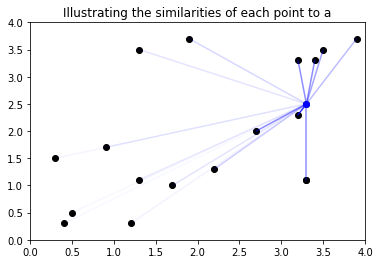

In [32]:
similarities_to_a = Sim([x1,a])
fig, ax = plt.subplots()
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.scatter(points[:,0],points[:,1],color="black")
ax.scatter(a[0],a[1],color="blue")
ax.set_title("Illustrating the similarities of each point to a")
for i, sim_to_a in enumerate(similarities_to_a):
    plt.plot([points[i,0],a[0]],[points[i,1],a[1]], alpha=sim_to_a.numpy(),color="blue")

Notice the operator for equivalence $p \leftrightarrow q$; in LTN, it is simply implemented as $(p \rightarrow q)\land(p \leftarrow q)$ using one operator for conjunction and one operator for implication.

In [7]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.And_Prod(),ltn.fuzzy_ops.Implies_Reichenbach()))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

If there are several closed formulas in $\mathcal{K}$, their truth values need to be aggregated.
We recommend to use the generalized mean inspired operator `pMeanError`, already used to implement $\forall$. 
The hyperparameter again allows flexibility in how strict the formula aggregation is ($p = 1$ corresponds to `mean`; $p \to +\inf$ corresponds to `min`).

The knowledgebase should be written inside of a function that is decorated with `tf.function`. This Tensorflow decorator compiles the function into a callable TensorFlow graph (static).

In [9]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=2)

@tf.function
def axioms():
    axioms = [
        C([a,l_a]),
        C([b,l_b]),
        Forall(
            [x1,x2,l],
            Implies( Sim([x1,x2]),
                    Equiv(C([x1,l]),C([x2,l]))
                   )
        )
    ]
    kb_sat = formula_aggregator(tf.stack(axioms))
    return kb_sat

**It is important to always run (forward pass) the knowledgebase once before training, as Tensorflow initializes weights and compiles the graph during the first call.**

In [10]:
axioms()

<tf.Tensor: shape=(), dtype=float32, numpy=0.46948296>

Eventually, one can write a custom training loop in Tensorflow.

In [11]:
trainable_variables = C.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(2000):
    with tf.GradientTape() as tape:
        loss = 1. - axioms()
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms()))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms()))

Epoch 0: Sat Level 0.471
Epoch 200: Sat Level 0.832
Epoch 400: Sat Level 0.942
Epoch 600: Sat Level 0.952
Epoch 800: Sat Level 0.954
Epoch 1000: Sat Level 0.957
Epoch 1200: Sat Level 0.959
Epoch 1400: Sat Level 0.959
Epoch 1600: Sat Level 0.959
Epoch 1800: Sat Level 0.959
Training finished at Epoch 1999 with Sat Level 0.959


After a few epochs, the system has learned to identify samples close to the point $a$ (resp. $b$) as belonging to class $A$ (resp. $B$) based on the rules of the knowledgebase.

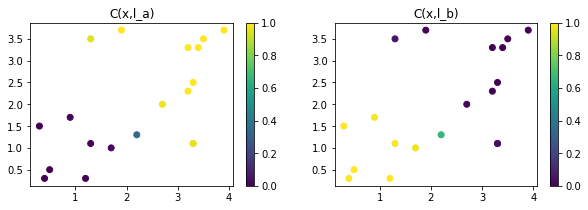

In [30]:
fig = plt.figure(figsize=(10,3))
fig.add_subplot(1,2,1)
plt.scatter(x1[:,0],x1[:,1],c=C([x1,l_a]).numpy(),vmin=0,vmax=1)
plt.title("C(x,l_a)")
plt.colorbar()
fig.add_subplot(1,2,2)
plt.scatter(x1[:,0],x1[:,1],c=C([x1,l_b]).numpy(),vmin=0,vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();

## Special Cases

### Variables grounded by batch

When working with batches of data, grounding the variables with different values at each step:
1. Pass the values in arguments to the knowledgebase function,
2. Create the ltn variables within the function. 

```python
@tf.function
def axioms(data_x, data_y):
    x = ltn.variable("x", data_x)
    y = ltn.variable("y", data_y)
    return Forall([x,y],P([x,y]))

...
for epoch in range(epochs):
    for batch_x, batch_y in dataset:
        with tf.GradientTape() as tape:
            loss_value = 1. - axioms(batch_x, batch_y)
        grads = tape.gradient(loss_value, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
```

### Variables denoting a sequence of trainable constants

When a variable denotes a sequence of trainable constants (embeddings):
1. Do not create the variable outside the scope of `tf.GradientTape()`,
2. Create the variable within the training step function.

```python
c1 = ltn.constant([2.1,3], trainable=True)
c2 = ltn.constant([4.5,0.8], trainable=True)
# Do not assign the variable here. Tensorflow would not keep track of the 
# gradients between c1/c2 and x during training.
# x = ltn.variable("x", tf.stack([c1,c2]))
...
@tf.function
def axioms():
    # The assignation must be done within the tf.GradientTape, 
    # inside of the training step function.
    x = ltn.variable("x",tf.stack([c1,c2]))
    return Forall(x,P(x))
...
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss_value = 1. - axioms()
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
```